In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from distutils.util import strtobool

import collections
from collections import namedtuple
from itertools import count

import numpy as np

import json
import time
import random
import os
import copy
import argparse
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import accuracy_score

from tqdm import tqdm 

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space

import matplotlib.pyplot as plt
%matplotlib inline

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

SEED = 1
set_seed(SEED)

In [2]:
def sort_by_x(X):
    for i,data in enumerate(X):
        middle_point = int(len(data)/2)
        x = data[:middle_point]
        y = data[middle_point:]
        sorted_xy = np.asarray([[a,x] for a,x in sorted(zip(data[:middle_point],data[middle_point:]))])
        new_data = np.concatenate((sorted_xy[:,0], sorted_xy[:,1]), axis=None)
        X[i] = new_data
    return X

In [3]:
N_DISCRETE_ACTIONS = 5 # Number of networks

class NAS_Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                 data_path, 
                 reward_penalty=0.0, 
                 naction_ending=5, 
                 step_sampling=False, 
                 offline_max_remove_data_perc = 0.3, 
                 offline_max_remove_network = 2):
        super(NAS_Env, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
        
        self.data_path = data_path
        self.offline_max_remove_data_perc = offline_max_remove_data_perc
        self.offline_max_remove_network = offline_max_remove_network 
        
        self.X_train, self.y_train, self.X_test, self.y_test, self.r_train, self.r_test = self.load_data()
        
        self.format_offline_train()
        self.format_offline_test()
        
        self.reward_range = (-1,1)
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=-5, high=5, shape=(2, 80), dtype=np.float16)
        
        self.reward_penalty = reward_penalty
        self.naction_ending = naction_ending
        self.step_sampling = step_sampling
        
        self.set_train_mode()
        
        self.current_dataset_id  = 0
        
        self.set_current_dataset()
        
        self.current_mask = []
        self.current_step = 1
        self.current_observation = self.get_observation()
        
        self.history_action = []
        self.history_rewards = []
        self.history_max_possible_rewards = []
         
        
    def set_train_mode(self):
        
        self.datasets = self.X_train
        self.ys = self.y_train
        self.rewards = self.r_train
        
    def set_test_mode(self):
        
        self.datasets = self.X_test
        self.ys = self.y_test
        self.rewards = self.r_test 
        
    def set_current_dataset(self):
        
        self.current_dataset = self.datasets[self.current_dataset_id].reshape((2,80))
        self.current_ys = self.ys[self.current_dataset_id]
        self.current_rewards = self.rewards[self.current_dataset_id] 
        self.current_possible_actions = [i for i in range(5) if np.isnan(self.current_rewards[i]) == False]

    def step(self, action):
        
        done = (self.current_step >= self.naction_ending and len(np.unique(
            self.history_action[-self.naction_ending:])) == 1) or (self.current_step == self.current_dataset.shape[1] - 1)
        
        full_reward = self.current_rewards[action]
        discounted_reward = full_reward * np.exp(-self.current_step * self.reward_penalty)
        
        max_possible_reward = np.nanmax(self.current_rewards)
        discounted_max_possible_reward = max_possible_reward * np.exp(-self.current_step * self.reward_penalty)
        
        self.history_action.append(action)
        self.history_rewards.append(discounted_reward)
        self.history_max_possible_rewards.append(discounted_max_possible_reward)
        
        self.current_step +=1
        self.current_observation = self.get_observation()
        
        return self.current_observation, discounted_reward, done, ""
        
         
    def get_observation(self):
        
        step_mask = np.zeros(self.current_dataset.shape[1])
        
        if self.step_sampling:
            available_idxs = list(set(range(len(step_mask))).difference(set(self.current_mask)))
            chosen_idx = np.random.choice(available_idxs)
            self.current_mask.append(chosen_idx)
        else:
            self.current_mask = list(range(self.current_step))
        
        step_mask[self.current_mask] = 1.0
        
        new_obs = copy.deepcopy(self.current_dataset)
        
        new_obs[0, :] = new_obs[0,:] * step_mask
        new_obs[1, :] = new_obs[1,:] * step_mask
        return new_obs
         
    # Execute one time step within the environment
    
    def reset(self, train = False):
        
        if train == True:
            self.set_train_mode()
        else:
            self.set_test_mode()
            
        self.current_dataset_id  = random.randint(0, self.datasets.shape[0]-1)
        self.set_current_dataset()
        
        self.current_mask = []
        self.current_step = 1
        self.current_observation = self.get_observation()
        
        self.history_action = []
        self.history_rewards = []
        self.history_max_possible_rewards = []
        
    # Reset the state of the environment to an initial state
    
    def render(self, mode='human', close=False):
        print("Error 404")
    # Render the environment to the screen
    
    def load_data(self):
        
        with open(self.data_path, "r") as f:
            data = json.load(f)
        # # keep only winning networks
        X, y, r = [], [], []
        n_networks = len(np.unique(data["actions"]))
        n_func = len(data["states"]) // n_networks
        # # print(n_networks, n_func)
        for f_i in range(n_func):
            scores_i = []
            actions_i = []
            for n_i in range(n_networks):
                i = f_i * n_networks + n_i
                scores_i.append(data["scores"][i])
                actions_i.append(data["actions"][i])
            X.append(data["states"][i])
            y.append(actions_i)
            r.append(scores_i)
        X = np.array(X)
        y = np.array(y)
        r = np.array(r)
        
        print(X.shape)
        print(y.shape)
        print(r.shape)
        # fix action ordering
        idx_order = np.argsort(y[0])
        y = y[:, idx_order]
        r = r[:, idx_order]
        idxs = np.arange(X.shape[0])
        test_split = int(0.33 * len(idxs))
        np.random.shuffle(idxs)
        
        idxs_train = idxs[:-test_split]
        idxs_test = idxs[-test_split:]
        
        X_train = X[idxs_train]
        y_train = y[idxs_train]
        r_train = r[idxs_train]
        
        X_test = X[idxs_test]
        y_test = y[idxs_test]
        r_test = r[idxs_test]
        
        return sort_by_x(X_train), y_train, sort_by_x(X_test), y_test, r_train, r_test 
    

    def format_offline_train(self):
        
        for i, (x, r) in enumerate(zip(self.X_train, self.r_train)):
    
            number_max_to_be_removed = int(self.offline_max_remove_data_perc * 80) 
            number_to_be_removed = np.random.randint(number_max_to_be_removed+1, size=1)[0]
    
            if number_to_be_removed > 0:
    
                index_to_be_removed = np.array(random.sample(range(0, 80), number_to_be_removed))
                index_to_be_removed2 = index_to_be_removed + 80
    
                total_index = np.concatenate((index_to_be_removed, index_to_be_removed2))
                x[total_index] = 0.0
        
            number_network_to_be_removed = np.random.randint(self.offline_max_remove_network+1, size=1)[0]
    
            if number_network_to_be_removed  > 0:
    
                index_network_to_be_removed = np.array(random.sample(range(0, 5), number_network_to_be_removed))
                r[index_network_to_be_removed] = None
            
    def format_offline_test(self):
        
        for i, (x, r) in enumerate(zip(self.X_test, self.r_test)):
    
            number_max_to_be_removed = int(self.offline_max_remove_data_perc * 80) 
            number_to_be_removed = np.random.randint(number_max_to_be_removed +1, size=1)[0]
    
            if number_to_be_removed > 0:
    
                index_to_be_removed = np.array(random.sample(range(0, 80), number_to_be_removed))
                index_to_be_removed2 = index_to_be_removed + 80
    
                total_index = np.concatenate((index_to_be_removed, index_to_be_removed2))
                x[total_index] = 0.0
        
            number_network_to_be_removed = np.random.randint(self.offline_max_remove_network+1, size=1)[0]
    
            if number_network_to_be_removed  > 0:
    
                index_network_to_be_removed = np.array(random.sample(range(0, 5), number_network_to_be_removed))
                r[index_network_to_be_removed] = None
        
        

In [4]:
data_path = "polynome_ready_for_training.json"
SHUFFLE_SAMPLES = True

env = NAS_Env(data_path, 
              reward_penalty=0.001,
              naction_ending=5, 
              step_sampling=SHUFFLE_SAMPLES, 
              offline_max_remove_data_perc = 0.4,
              offline_max_remove_network = 1)

(900, 160)
(900, 5)
(900, 5)


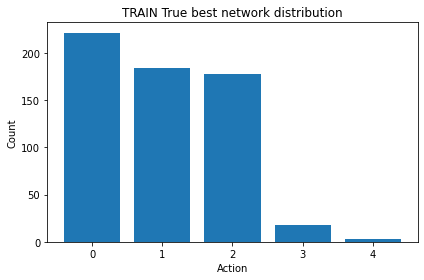

In [5]:
plt.bar(x = list(range(5)), height= np.bincount(np.nanargmax(env.r_train, axis=1)))
plt.title("TRAIN True best network distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

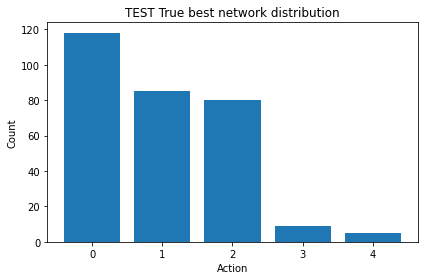

In [6]:
plt.bar(x = list(range(5)), height= np.bincount(np.nanargmax(env.r_test, axis=1)))
plt.title("TEST True best network distribution")
plt.xlabel("Action")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','possible_actions'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        else:
            return False
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        return True

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    def reset(self):
        self.memory = []
        self.position = 0 

In [8]:
class DQN(nn.Module):
    def __init__(self, env):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(env.observation_space.shape[0]* env.observation_space.shape[1], 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, env.action_space.n)

    def forward(self, x):
        x = x.float()
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = torch.tanh(self.fc3(x))
        return x

In [9]:
policy_net = DQN(env)
target_net = DQN(env)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(100000)

In [10]:
total_steps_done = 0

BATCH_SIZE = 50
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200

def get_action(state):
    
    global total_steps_done
    sample = random.random()
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * total_steps_done / EPS_DECAY)
    
    total_steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            policy_net.eval()
            actions = policy_net(state)
            policy_net.train()
            
            ranking = torch.argsort(actions, descending=True)[0]
            for action_candidate in ranking:
                if action_candidate in env.current_possible_actions:
                    return torch.tensor(action_candidate)   
    else:
        return torch.tensor(np.random.choice(env.current_possible_actions))

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
   
    non_final_next_states = torch.reshape(non_final_next_states,(int(non_final_next_states.shape[0]/2), 160))
    
    
    state_batch = torch.reshape(torch.cat(batch.state),(BATCH_SIZE, 160))
    action_batch = torch.reshape(torch.stack(batch.action), (BATCH_SIZE,1))
    reward_batch = torch.cat(batch.reward)
    #possible_actions = torch.stack(batch.possible_actions)
    

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    #target_actions = target_net(non_final_next_states)
    
    #print(target_actions)
    #best_target_allowed_action  = []
    #for actions_values, possible_actions in zip(target_actions, batch.possible_actions):
        #print(actions_values[possible_actions])
        #print(torch.max(actions_values[possible_actions]))
    #print(best_target_allowed_action)
        
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [11]:
num_episodes = 1000
TARGET_UPDATE = 5

episode_predicted_networks = []
episode_best_true_networks = []
episode_true_networks_r2 = []
episode_rewards = []
episode_max_possible_rewards = []
episode_durations = [] 

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    env.reset(train=True)
        
    state = torch.from_numpy(env.current_observation)
    
    for i in range(80):
        
        action = get_action(state.flatten().unsqueeze(0))
        _, reward, done, _ = env.step(action)
        reward = torch.tensor([reward])

        next_state = torch.from_numpy(env.current_observation)
        # Observe new state
        
        if done:
            next_state = None

        # Store the transition in memory
        
        success_push = memory.push(state,
                    action, 
                    next_state, 
                    reward,
                    torch.tensor(env.current_possible_actions))
    
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model() 
        
        if done:
            
            episode_predicted_network = env.history_action[-2].numpy()
            episode_best_true_network = np.nanargmax(env.current_rewards)
            episode_reward = sum(env.history_rewards)
            episode_max_possible_reward = sum(env.history_max_possible_rewards)
            
            episode_predicted_networks.append(episode_predicted_network)
            episode_true_networks_r2.append(env.current_rewards)
            episode_best_true_networks.append(episode_best_true_network)
            episode_rewards.append(episode_reward)
            episode_max_possible_rewards.append(episode_max_possible_reward)
            episode_durations.append(i + 1) 
            
            break
            

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.38it/s]

Complete


In [12]:
def calculate_topk(predicted_network, score_networks, k):
    
    in_topk = 0
    
    for predicted, scores in zip(predicted_network,score_networks):
        
        top_idx = np.argsort(scores)[-k:]
        
        if predicted in top_idx:
            in_topk += 1
            
    return in_topk/len(predicted_network)  

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [13]:
top1 = calculate_topk(episode_predicted_networks[-200:], episode_true_networks_r2[-200:], k=1)
top2 = calculate_topk(episode_predicted_networks[-200:], episode_true_networks_r2[-200:], k=2)
print("Top1:", top1,", Top 2:", top2)

Top1: 0.2 , Top 2: 0.655


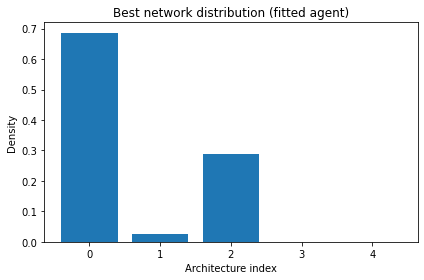

In [14]:
plt.bar(x = list(range(5)), height=np.bincount(np.array(episode_predicted_networks), minlength=5)/len(episode_predicted_networks))
plt.title("Best network distribution (fitted agent)")
plt.xlabel("Architecture index")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"./figures/arch_distribution-predict.pdf", dpi=1000)
plt.show()

In [15]:
filter_size = 11
pad = int((filter_size - 1)/2)

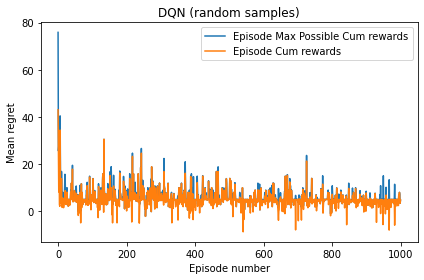

In [16]:
x_steps = np.linspace(0, num_episodes -1, num= num_episodes, dtype = int)
plt.plot(x_steps, np.array(episode_max_possible_rewards), label="Episode Max Possible Cum rewards")
plt.plot(x_steps, np.array(episode_rewards), label="Episode Cum rewards")
envtype = "random" if SHUFFLE_SAMPLES else "sequential"
plt.title(f"DQN ({envtype} samples)")
plt.xlabel("Episode number")
plt.ylabel("Mean regret")
plt.legend()
plt.tight_layout()

plt.savefig(f"./figures/regret-DQN-{envtype}.pdf", dpi=1000)

plt.show()

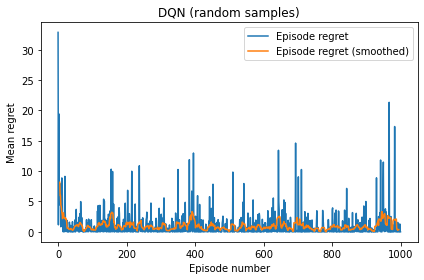

In [17]:
x_steps = np.linspace(0, num_episodes -1, num= num_episodes, dtype = int)
plt.plot(x_steps, np.array(episode_max_possible_rewards) - np.array(episode_rewards), label="Episode regret")
plt.plot(x_steps[pad:-pad], moving_average(np.array(episode_max_possible_rewards) - np.array(episode_rewards), filter_size), label="Episode regret (smoothed)")
envtype = "random" if SHUFFLE_SAMPLES else "sequential"
plt.title(f"DQN ({envtype} samples)")
plt.xlabel("Episode number")
plt.ylabel("Mean regret")
plt.legend()
plt.tight_layout()

plt.savefig(f"./figures/regret-DQN-{envtype}.pdf", dpi=1000)

plt.show()

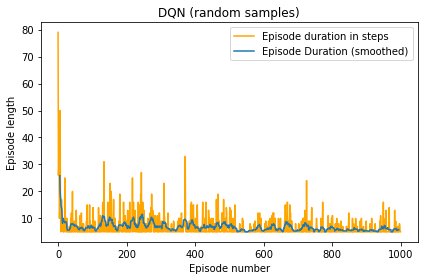

In [18]:
plt.plot(x_steps, episode_durations,c='orange', label="Episode duration in steps")
plt.plot(x_steps[pad:-pad], moving_average(episode_durations, filter_size), label="Episode Duration (smoothed)")
envtype = "random" if SHUFFLE_SAMPLES else "sequential"
plt.title(f"DQN ({envtype} samples)")
plt.xlabel("Episode number")
plt.ylabel("Episode length")
plt.legend()
plt.tight_layout()

plt.savefig(f"./figures/duration-DQN-{envtype}.pdf", dpi=1000)
plt.show()

In [36]:
eval_episode_predicted_networks = []
eval_episode_best_true_networks = []
eval_episode_true_networks_r2 = []
eval_episode_rewards = []
eval_episode_max_possible_rewards = []
eval_episode_durations = [] 
def eval():
    policy_net.eval()
    print(env.datasets.shape[0])
    for i_episode in tqdm(range(env.r_test.shape[0])):
    # Initialize the environment and state
        env.reset(train=False)
        state = torch.from_numpy(env.current_observation)
        for i in range(80):
            actions = policy_net(state.flatten().unsqueeze(0))
            action = torch.argmax(actions)
            _, reward, done, _ = env.step(action)
            reward = torch.tensor([reward])
            next_state = torch.from_numpy(env.current_observation)
            # Observe new state
            if done:
                next_state = None
            # Move to the next state
            state = next_state
            # Perform one step of the optimization (on the target network)
            if done:
                eval_episode_predicted_network = env.history_action[-2].numpy()
                eval_episode_best_true_network = np.nanargmax(env.current_rewards)
                eval_episode_reward = sum(env.history_rewards)
                eval_episode_max_possible_reward = sum(env.history_max_possible_rewards)
                eval_episode_predicted_networks.append(eval_episode_predicted_network)
                eval_episode_true_networks_r2.append(env.current_rewards)
                eval_episode_best_true_networks.append(eval_episode_best_true_network)
                eval_episode_rewards.append(eval_episode_reward)
                eval_episode_max_possible_rewards.append(eval_episode_max_possible_reward)
                eval_episode_durations.append(i + 1) 
                break


In [37]:
eval()

 37%|█████████████████████████████▎                                                 | 110/297 [00:00<00:00, 547.94it/s]

297


100%|███████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 545.92it/s]


In [38]:
eval_episode_predicted_networks

[array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=int64),
 array(0, dtype=

In [39]:
eval_episode_best_true_networks

[2,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 3,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 4,
 0,
 0,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 1,
 1,
 3,
 0,
 0,
 4,
 0,
 1,
 0,
 3,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 3,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 2,
 1,
 3,
 1,
 0,
 0,
 0,
 1,
 1,
 3,
 1,
 0,
 2,
 0,
 1,
 4,
 2,
 2,
 0,
 2,
 1,
 3,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,


In [40]:
eval_episode_true_networks_r2

[array([ 0.99853281, -1.        ,  0.99961624, -1.        ,  0.99855812]),
 array([0.97152107, 0.97504595, 0.94259364, 0.71871718,        nan]),
 array([ 0.99853281, -1.        ,  0.99961624, -1.        ,  0.99855812]),
 array([ 0.31490721,  0.        ,  0.54167821, -1.        , -1.        ]),
 array([0.9945023 , 0.99587207,        nan, 0.        , 0.87632009]),
 array([ 0.43448931,  0.31047192,  0.08937821, -1.        , -0.5069959 ]),
 array([ 0.57760403,  0.64750059,  0.6095677 ,  0.02152909, -0.11773221]),
 array([ 0.8400373 ,  0.98369399,  0.88224437,  0.        , -1.        ]),
 array([ 0.7771627 ,  0.        ,         nan, -0.10781646,  0.36933704]),
 array([0.9945023 , 0.99587207,        nan, 0.        , 0.87632009]),
 array([ 0.97991654, -1.        ,  0.99159774, -0.45477071,  0.84221927]),
 array([ 0.48770054,  0.99621027,  0.38350433,         nan, -1.        ]),
 array([ 0.64341256, -1.        ,         nan, -1.        , -0.59591927]),
 array([ 0.98025269, -1.        ,  0.809

In [ ]:
eval_episode_best_true_networks = []
eval_episode_true_networks_r2 = []
eval_episode_rewards = []
eval_episode_max_possible_rewards = []
eval_episode_durations = [] 